In [1]:
#location of the s3 bucket
# #set private path
# private_path = "s3://{}/ads-508-anime/".format(bucket)
# print(private_path)
# %store -r private_path

In [2]:

# #install the each run
# ! pip install pyathena
# #!pip install awswrangler


In [3]:


#libraries that will be used
import boto3
import pandas as pd
import pyathena as pa
import sagemaker
from sklearn.preprocessing import MultiLabelBinarizer
from pyathena.pandas.cursor import PandasCursor # results are taking to long to query this cursor speeds up process
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyathena import connect # for querying in pandas



In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## create Athena staging area and database

In [5]:
#Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
dbname = 'myanimelist'

In [8]:


statement = "CREATE DATABASE IF NOT EXISTS {}".format(dbname)
print(statement)



CREATE DATABASE IF NOT EXISTS myanimelist


In [9]:
pd.read_sql(statement, conn)

""


In [10]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,myanimelist


In [11]:


if dbname in df_show.values:
    ingest_create_athena_db_passed = True



In [12]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [13]:
#create athena table in Glue


import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name



## Create the five tables

# Important note-- In Athena create five different folders for the create table to pull from in the locations, upload  the files once the folders are created
- s3://ads-508-anime/animelist/
- s3://ads-508-anime/anime/
- s3://ads-508-anime/synopsis/
- s3://ads-508-anime/rating_complete/
- s3://ads-508-anime/watching_status/

In [14]:
#code for dropping tables if needed, during setup had various Issues creating the table
# pd.read_sql('DROP TABLE myanimelist.animelist', con=conn)

In [59]:

#create animelist table
animelist_table = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         user_id integer,
         anime_id integer,
         rating integer,
         watching_status integer,
         watched_episodes integer
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(dbname, 'animelist', 's3://ads-508-anime/animelist/')
pd.read_sql(animelist_table, con=conn)



""


In [60]:
#inspect the table

pd.read_sql('SELECT * FROM %s.%s LIMIT 20' % (dbname, 'animelist'), con=conn)







,user_id,anime_id,rating,watching_status,watched_episodes
0,336145,2251,10,2,13
1,343247,2787,9,2,24
2,130592,235,9,1,752
3,38258,10572,0,3,1
4,196188,22729,8,2,12
5,161132,1119,7,2,1
6,86484,8937,0,6,0
7,175224,20909,6,2,7
8,54075,28423,4,2,25
9,216046,16524,7,1,3


In [172]:
# pd.read_sql('DROP TABLE myanimelist.anime', con=conn)

""


In [173]:


anime_table = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         MAL_ID int, Name string, Score string, Genres string, English_name string, Japanese_name string, Type string, 
         Episodes string, Aired string, Premiered string, Producers string, 
         Licensors string, Studios string, Source string, Duration string, Rating string, Ranked string,
         Popularity int, Members int, Favorites int, Watching int, Completed int, 
         On_Hold int, Dropped int, Plan_to_Watch string, 
         Score_10 string, Score_9 string, Score_8 string, Score_7 string, Score_6 string, Score_5 string, Score_4 string, Score_3 string, Score_2 string, Score_1 string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  STORED AS TEXTFILE LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(dbname, 'anime', 's3://ads-508-anime/anime/')
pd.read_sql(anime_table, con=conn)



""


In [175]:
#inspect anime_table
pd.read_sql('SELECT * FROM %s.%s LIMIT 2000' % (dbname,'anime'), con=conn)

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_10,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2179,Tokimeki Memorial: Forever With You,6.12,"Drama, Romance, School",Unknown,ときめきメモリアル 〜forever with you〜,OVA,2,"Jun 17, 1999 to Oct 8, 1999",Unknown,...,36.0,37.0,83.0,176.0,188.0,145.0,61.0,33.0,12.0,14.0
1996,2180,Slow Step,6.56,"Slice of Life, Comedy, Sports, Romance, School...",Slow Step,スローステップ,OVA,5,"Jun 1, 1991 to Nov 1, 1991",Unknown,...,35.0,48.0,124.0,215.0,171.0,87.0,32.0,12.0,7.0,12.0
1997,2181,TANK S.W.A.T. 01,4.93,"Police, Mecha",TANK S.W.A.T. 01,警察戦車隊,OVA,1,"Mar 24, 2006",Unknown,...,18.0,15.0,31.0,127.0,159.0,223.0,142.0,88.0,84.0,72.0
1998,2182,Robot Carnival,7.28,"Sci-Fi, Fantasy, Mecha",Robot Carnival,ロボット・カーニバル,OVA,1,"Jul 21, 1987",Unknown,...,534.0,800.0,1533.0,1747.0,986.0,401.0,174.0,66.0,23.0,15.0


In [176]:
# pd.read_sql('DROP TABLE myanimelist.synopsis', con=conn)

In [177]:


synopsis_table = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         MAL_ID int,
         Name string,
         Score string,
         Genres string,
         sypnopsis string
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  STORED AS TEXTFILE LOCATION '{}'
  TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(dbname, 'synopsis', 's3://ads-508-anime/synopsis/')
pd.read_sql(synopsis_table, con=conn)




""


In [178]:
pd.read_sql('SELECT * FROM %s.%s LIMIT 20' % (dbname,'synopsis'), con=conn)


,mal_id,name,score,genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college..."
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent..."


In [179]:
pd.read_sql('DROP TABLE myanimelist.ratings', con=conn)

""


In [180]:

#create rating_table


rating_table = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         user_id int,
         anime_id int,
         rating int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(dbname, 'ratings', 's3://ads-508-anime/rating_complete/')
pd.read_sql(rating_table, con=conn)




""


In [181]:
 pd.read_sql('SELECT * FROM %s.%s LIMIT 20' % (dbname,'ratings'), con=conn)


,user_id,anime_id,rating
0,220554,36266,6
1,220554,631,8
2,220554,34497,7
3,220554,2963,7
4,220554,35790,8
5,220554,33,9
6,220554,36407,6
7,220554,37302,6
8,220554,34451,8
9,220554,24439,8


In [182]:
# pd.read_sql('DROP TABLE myanimelist.watchingstatus', con=conn)

In [183]:
#create watchlist_table

watchlist_table = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         status int,
         description string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('compressionType'='gzip', 'skip.header.line.count'='1')""".format(dbname, 'watching_status', 's3://ads-508-anime/watching_status/')
pd.read_sql(watchlist_table, con=conn)



""


In [184]:
 pd.read_sql('SELECT * FROM %s.%s LIMIT 20' % (dbname,'watching_status'), con=conn)


,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [185]:
#check created tables
statement = "SHOW TABLES in {}".format(dbname)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,anime
1,animelist
2,ratings
3,synopsis
4,watching_status


In [186]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed             -> True
setup_dependencies_passed                  -> True
setup_iam_roles_passed                     -> True
setup_instance_check_passed                -> True
setup_s3_bucket_passed                     -> True
test_data_bias_s3_uri                      -> 's3://sagemaker-us-east-1-229141875778/bias/test_d


# Construct DataFrames

In [187]:

## had issue loading this files using athena changed cursor to pandas cursor

# anime = pd.read_sql('SELECT * FROM %s.%s' % (dbname, 'anime'), con=conn)
# synopsis = anime_list = pd.read_sql('SELECT * FROM %s.%s' % (dbname, 'synopsis'), con=conn)
# ratings = anime_list = pd.read_sql('SELECT * FROM %s.%s' % (dbname, 'ratings'), con=conn)
# watching_status = anime_list = pd.read_sql('SELECT * FROM %s.%s' % (dbname, 'watching_status'), con=conn)
# anime_list = pd.read_sql('SELECT * FROM %s.%s' % (dbname, 'animelist'), con=conn)



## Bypassing the default pyathena cursor and using a more efficient PandasCursor

In [188]:


cursor = pa.connect(s3_staging_dir=s3_staging_dir, region_name='us-east-1',cursor_class=PandasCursor).cursor()



In [189]:


anime_list = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'animelist')).as_pandas()
anime = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'anime')).as_pandas()
watching_status = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'watching_status')).as_pandas()

## redundant tables
#synopsis = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'synopsis')).as_pandas()
#ratings = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'ratings')).as_pandas()



# EDA

In [190]:
anime_list.dtypes

user_id             Int64
anime_id            Int64
rating              Int64
watching_status     Int64
watched_episodes    Int64
dtype: object

In [191]:
anime_list.dtypes

user_id             Int64
anime_id            Int64
rating              Int64
watching_status     Int64
watched_episodes    Int64
dtype: object

In [192]:
anime_list.dtypes

user_id             Int64
anime_id            Int64
rating              Int64
watching_status     Int64
watched_episodes    Int64
dtype: object

# checking for Null values

In [193]:
anime_list.dtypes

user_id             Int64
anime_id            Int64
rating              Int64
watching_status     Int64
watched_episodes    Int64
dtype: object

In [194]:
anime.isna().sum()


mal_id           0
name             0
score            0
genres           0
english_name     0
japanese_name    0
type             0
episodes         0
aired            0
premiered        0
producers        0
licensors        0
studios          0
source           0
duration         0
rating           0
ranked           0
popularity       0
members          0
favorites        0
watching         0
completed        0
on_hold          0
dropped          0
plan_to_watch    0
score_10         0
score_9          0
score_8          0
score_7          0
score_6          0
score_5          0
score_4          0
score_3          0
score_2          0
score_1          0
dtype: int64

In [195]:
watching_status.isna().sum()

status         0
description    0
dtype: int64

# Genres

In [196]:
genre_list = anime['genres'].apply(lambda x: x.split(', '))


In [197]:
# Unique Genre
list(set(genre_list.sum()))

['Hentai',
 'Action',
 'Psychological',
 'School',
 'Music',
 'Samurai',
 'Yuri',
 'Romance',
 'Horror',
 'Mecha',
 'Ecchi',
 'Fantasy',
 'Game',
 'Kids',
 'Supernatural',
 'Space',
 'Shoujo',
 'Vampire',
 'Seinen',
 'Historical',
 'Shounen Ai',
 'Drama',
 'Harem',
 'Military',
 'Cars',
 'Josei',
 'Police',
 'Martial Arts',
 'Magic',
 'Shounen',
 'Super Power',
 'Yaoi',
 'Slice of Life',
 'Unknown',
 'Mystery',
 'Demons',
 'Parody',
 'Adventure',
 'Shoujo Ai',
 'Comedy',
 'Sci-Fi',
 'Sports',
 'Dementia',
 'Thriller']

In [198]:
genre_list

0        [Action, Adventure, Comedy, Drama, Sci-Fi, Space]
1                  [Action, Drama, Mystery, Sci-Fi, Space]
2        [Action, Sci-Fi, Adventure, Comedy, Drama, Sho...
3        [Action, Mystery, Police, Supernatural, Drama,...
4              [Adventure, Fantasy, Shounen, Supernatural]
                               ...                        
17557                   [Adventure, Mystery, Supernatural]
17558                       [Comedy, Horror, Supernatural]
17559    [Mystery, Dementia, Horror, Psychological, Sup...
17560                   [Adventure, Slice of Life, Comedy]
17561                                    [Action, Fantasy]
Name: genres, Length: 17562, dtype: object

In [199]:
mlb = MultiLabelBinarizer()
ohe = pd.DataFrame(mlb.fit_transform(genre_list), columns=mlb.classes_, index=genre_list.index)


In [200]:
ohe

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi,Yuri
0,1,1,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17558,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17559,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
17560,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Top 10 Most Common Genres

In [201]:

ohe.sum().sort_values(ascending=False).head(10)



Comedy           6029
Action           3888
Fantasy          3285
Adventure        2957
Kids             2665
Drama            2619
Sci-Fi           2583
Music            2244
Shounen          2003
Slice of Life    1914
dtype: int64

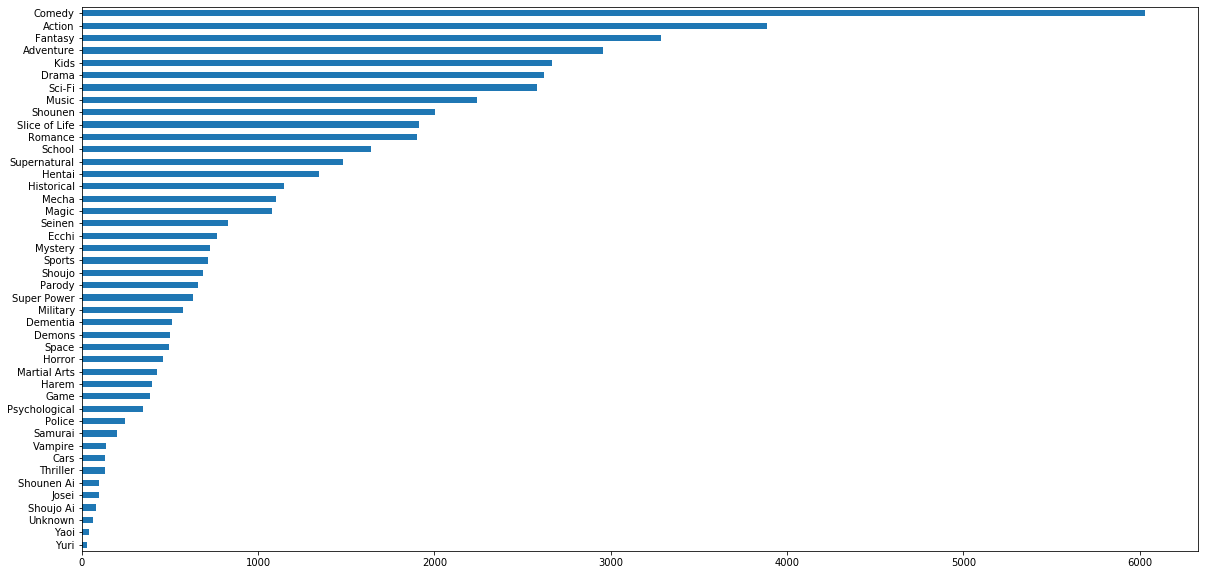

In [202]:
ohe.sum().sort_values(ascending=True).plot(kind='barh', figsize=(20, 10))

# Top 10 anime by average user scores

Note: Unable to coerce score to float dtype. Need to first replace value 'Unknown' with null


In [203]:


anime['score'] = anime['score'].replace({'Unknown': np.nan})
anime['score'] = anime['score'].astype('float')



In [204]:
anime.dtypes

mal_id             Int64
name              object
score            float64
genres            object
english_name      object
japanese_name     object
type              object
episodes          object
aired             object
premiered         object
producers         object
licensors         object
studios           object
source            object
duration          object
rating            object
ranked            object
popularity         Int64
members            Int64
favorites          Int64
watching           Int64
completed          Int64
on_hold            Int64
dropped            Int64
plan_to_watch     object
score_10          object
score_9           object
score_8           object
score_7           object
score_6           object
score_5           object
score_4           object
score_3           object
score_2           object
score_1           object
dtype: object

In [205]:
anime.sort_values(['score'], ascending=False).head(10)[['mal_id', 'name', 'score', 'genres']]


,mal_id,name,score,genres
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma..."
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,..."
6890,9253,Steins;Gate,9.11,"Thriller, Sci-Fi"
5268,11061,Hunter x Hunter (2011),9.10,"Action, Adventure, Fantasy, Shounen, Super Power"
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.10,"Action, Drama, Fantasy, Military, Mystery, Sho..."
9913,28977,Gintama°,9.10,"Action, Comedy, Historical, Parody, Samurai, S..."
4800,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama"
7261,15417,Gintama': Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S..."
9886,28851,Koe no Katachi,9.00,"Drama, School, Shounen"


# Common Genres by Top 10 average user scores

In [206]:
# Concatenate one-hot-encoded genres to anime list
anime_genres = pd.concat([anime, ohe], axis=1)

In [207]:
genres_by_user_score = anime_genres.sort_values(['score'], ascending=False).head(10)[ohe.columns.tolist()].sum().sort_values(ascending=False)



In [208]:
pd.DataFrame(genres_by_user_score[genres_by_user_score > 0], columns=['Count'])

,Count
Shounen,8
Action,7
Sci-Fi,5
Drama,5
Comedy,4
Fantasy,4
Military,4
Historical,3
Super Power,3
Samurai,3


# Individual User Ratings

In [209]:
anime_list

,user_id,anime_id,rating,watching_status,watched_episodes
0,336145,2251,10,2,13
1,343247,2787,9,2,24
2,130592,235,9,1,752
3,38258,10572,0,3,1
4,196188,22729,8,2,12
...,...,...,...,...,...
999995,82894,18679,8,2,24
999996,78032,12549,0,2,12
999997,67572,37450,0,6,0
999998,129806,31442,0,6,0


In [210]:
watching_status

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [211]:
user_ratings = pd.merge(anime_list, anime[['mal_id', 'name', 'score', 'genres']], left_on='anime_id', right_on='mal_id', how='inner')

In [212]:
user_ratings.head()

,user_id,anime_id,rating,watching_status,watched_episodes,mal_id,name,score,genres
0,336145,2251,10,2,13,2251,Baccano!,8.42,"Action, Comedy, Historical, Mystery, Supernatural"
1,228773,2251,9,2,13,2251,Baccano!,8.42,"Action, Comedy, Historical, Mystery, Supernatural"
2,61090,2251,10,2,13,2251,Baccano!,8.42,"Action, Comedy, Historical, Mystery, Supernatural"
3,26848,2251,9,2,13,2251,Baccano!,8.42,"Action, Comedy, Historical, Mystery, Supernatural"
4,195185,2251,8,2,13,2251,Baccano!,8.42,"Action, Comedy, Historical, Mystery, Supernatural"


# Filter by watched user watched or currently watching

In [213]:
user_ratings[user_ratings['watching_status'].isin([1, 2])].sort_values(['user_id'])

,user_id,anime_id,rating,watching_status,watched_episodes,mal_id,name,score,genres
476567,1,33486,8,2,25,33486,Boku no Hero Academia 2nd Season,8.33,"Action, Comedy, Super Power, School, Shounen"
227418,3,9863,9,2,77,9863,SKET Dance,8.25,"Comedy, School, Shounen"
511152,3,71,7,2,24,71,Full Metal Panic!,7.65,"Action, Military, Sci-Fi, Comedy, Mecha"
201326,3,10379,8,2,13,10379,Natsume Yuujinchou San,8.60,"Slice of Life, Demons, Supernatural, Drama, Sh..."
255608,4,1222,8,2,26,1222,Bokura ga Ita,7.31,"Slice of Life, Drama, Romance, Shoujo"
...,...,...,...,...,...,...,...,...,...
428360,353398,31630,6,2,24,31630,"Gyakuten Saiban: Sono ""Shinjitsu"", Igi Ari!",6.45,"Comedy, Drama, Mystery, Police"
442470,353398,1571,7,2,25,1571,Ghost Hunt,7.81,"Mystery, Comedy, Horror, Supernatural, Shoujo"
807777,353398,36144,0,1,0,36144,Garo: Vanishing Line,7.17,"Action, Demons, Supernatural, Fantasy"
561844,353398,5734,7,2,12,5734,Tayutama: Kiss on My Deity,6.78,"Harem, Romance, Supernatural"


In [214]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed             -> True
setup_dependencies_passed                  -> True
setup_iam_roles_passed                     -> True
setup_instance_check_passed                -> True
setup_s3_bucket_passed                     -> True
test_data_bias_s3_uri                      -> 's3://sagemaker-us-east-1-229141875778/bias/test_d
